In [1]:
import numpy as np
import pandas as pd
import pickle, itertools
from scipy.stats import spearmanr

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.pyplot import savefig
from matplotlib.ticker import FormatStrFormatter
%matplotlib inline

import seaborn as sns
sns.set_style("ticks")
sns.set_context(context='paper',font_scale=1.2)
sns.despine()

from utils_prediction.database import gbq_connect, gbq_query
con = gbq_connect()

Google Big Query Connection Established


<Figure size 432x288 with 0 Axes>

In [2]:
results_fpath = "/hpf/projects/lsung/projects/mimic4ds/artifacts"
fi_fpath = "results/concept_drift"
models = ['lr','rf','xgb','nn']
groups = ['2008 - 2010', '2011 - 2013', '2014 - 2016', '2017 - 2019']
hows = ["perm","boot"]
tasks = ['mortality','longlos']

analysis_tag = "baseline"
train_group = '2008 - 2010'

In [3]:
colors = sns.color_palette('deep')
model_colors = {
    'lr':colors[0],
    'rf':colors[3],
    'xgb':colors[2],
    'nn':colors[4]
    }
model_names = {
    'lr':'Logistic\nRegression',
    'rf':'Random\nForest',
    'xgb':'XGBoost',
    'nn':'Neural\nNetwork'
    }
task_names = {
    'mortality':'Mortality',
    'longlos':'Long LOS'
}
ylims = {
    'auc':{
        "alias":'AUROC',
        "mortality":[0.45, 0.95],
        "longlos":[0.45,0.85]
    },
    'auprc':{
        "alias":'AUPRC',
        "mortality":[0, 0.7],
        "longlos":[0.2,0.8]
    }
}

#### As a first step, plot the ROAR results for each model & year-group side by side

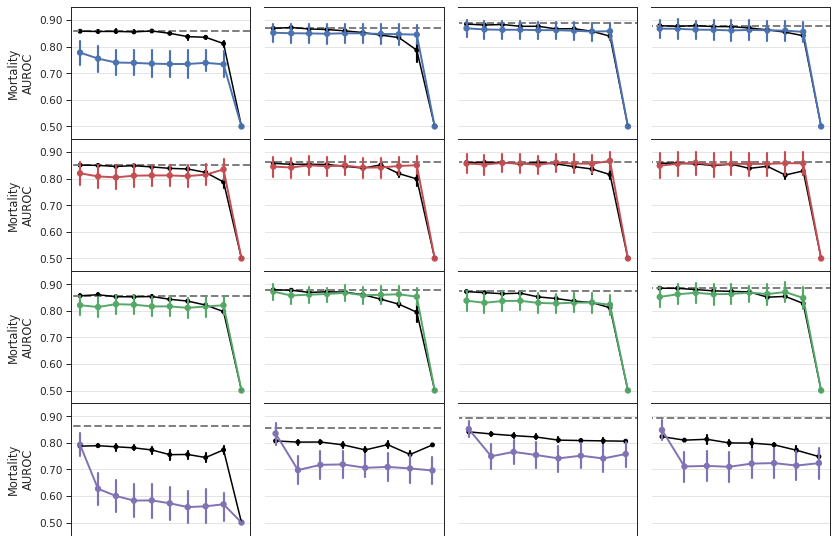

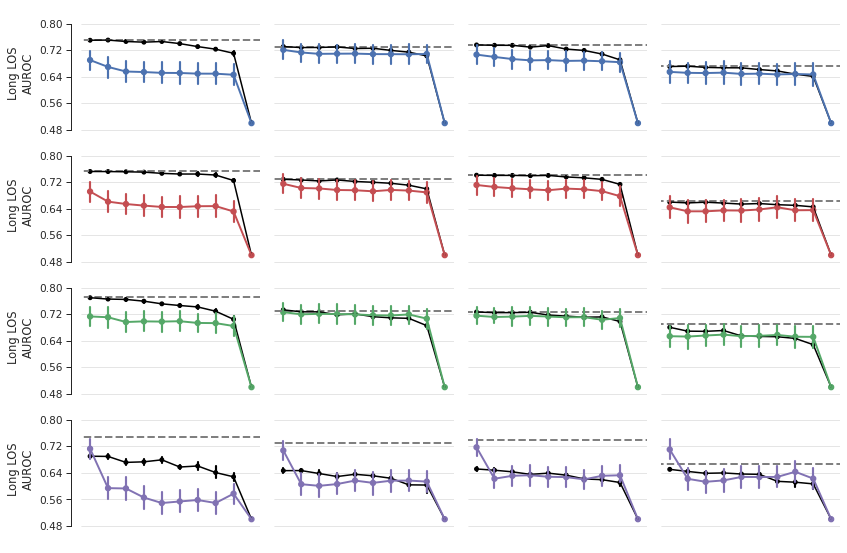

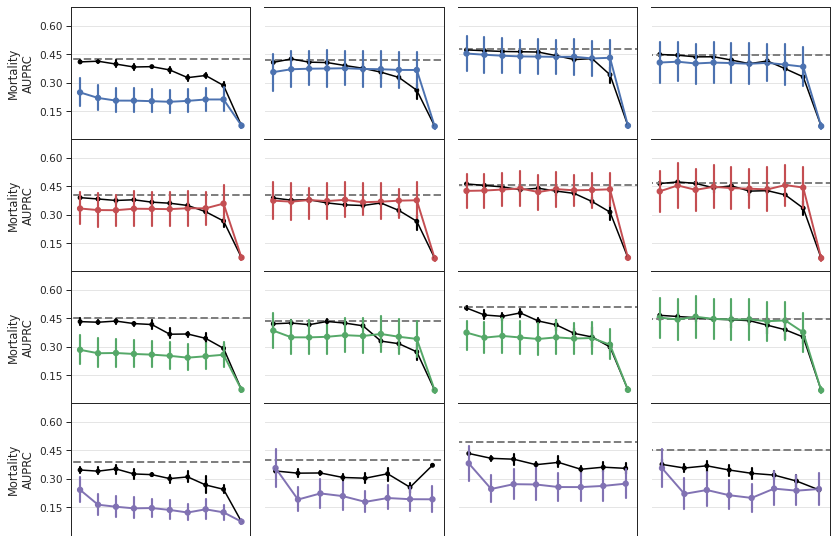

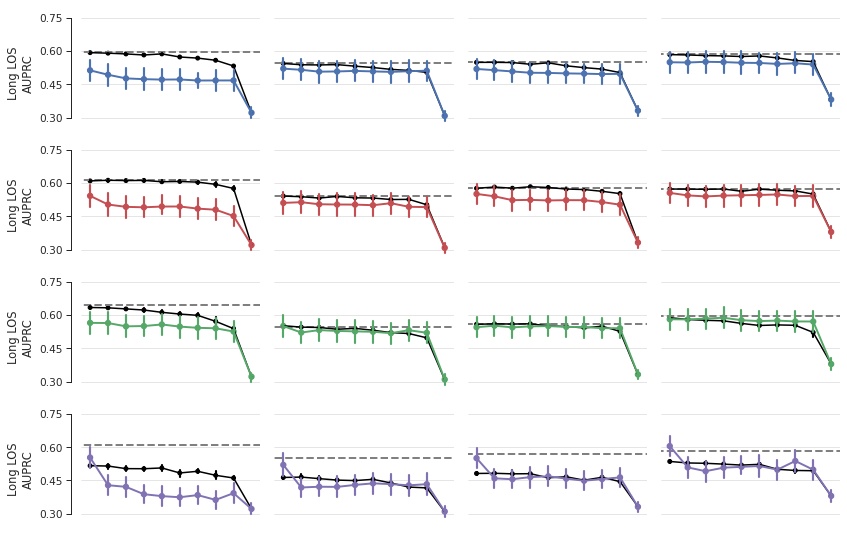

In [7]:
metrics = ['auc','auprc']
tasks = ['mortality','longlos']
imodels = ['lr','rf','xgb','nn']
igroups = ['2008 - 2010','2011 - 2013', '2014 - 2016', '2017 - 2019']
for metric in metrics:
    for i,task in enumerate(tasks):
        fig, axes = plt.subplots(len(models),len(igroups),figsize=(12,10))
        plt.tight_layout(w_pad=-2,h_pad=-2,rect=[0.05,0.15,1,0.95])
        for j,model in enumerate(imodels):
            for k,group in enumerate(igroups):
                # baseline
                fpath = f"{results_fpath}/analysis_id={task}/results/evaluate_models"
                fname = f"2008 - 2010_{group}_{analysis_tag}"
                baseline = pd.read_csv(f"{fpath}/{fname}.csv")
                df_baseline = baseline.query("metric==@metric and model==@model")
                # Random and top-down
                fpath = f"{results_fpath}/analysis_id={task}/results/concept_drift"
                fname = f"{model}_2008 - 2010_{group}_perm_{analysis_tag}_inspect"
                df = pd.read_csv(f"{fpath}/{fname}.csv")
                df_random = df.query("metric==@metric and features=='random'")#.groupby('perc_features').mean().reset_index()
                df_top = df.query("metric==@metric and features=='top'")
                df_top = df_top[['perc_features','CI_lower','CI_med','CI_upper']]
                df_top = df_top.melt(id_vars=['perc_features'],value_vars=['CI_lower','CI_med','CI_upper'],value_name='performance')
                # bottom up
                #fname = f"{model}_2008 - 2010_{group}_perm_{analysis_tag}_inspect_bottomup"
                #df = pd.read_csv(f"{fpath}/{fname}.csv")
                #df_bottom = df.query("metric==@metric and features=='top'")
                #df_bottom = df_bottom.melt(id_vars=['perc_features'],value_vars=['CI_lower','CI_med','CI_upper'],value_name='performance')
                # plot
                axes[j][k].plot(
                    [-100,100],
                    [df_baseline['performance'],df_baseline['performance']],
                    color = 'grey',
                    linewidth = 2,
                    linestyle ='--'
                )
                sns.pointplot(
                    data = df_random,
                    x = 'perc_features',
                    y = 'performance',
                    marker = 'o',
                    ax = axes[j][k],
                    color = 'black',
                    linestyles='-',
                    scale = 0.7,
                )
                #sns.pointplot(
                #    data = df_bottom,
                #    x = 'perc_features',
                #    y = 'performance',
                #    ax = axes[j][k],
                #    color = model_colors[model],
                #    scale = 0.9
                #)
                sns.pointplot(
                    data = df_top,
                    x = 'perc_features',
                    y = 'performance',
                    ax = axes[j][k],
                    color = model_colors[model],
                    scale = 0.9
                )

                axes[j][k].set_ylim(ylims[metric][task])
                axes[j][k].yaxis.set_major_locator(MaxNLocator(nbins=6,prune='both'))
                axes[j][k].grid(which='major', linewidth=0.5, axis='y')
                if k==0:
                    axes[j][k].set_ylabel(
                        f"{task_names[task]}\n{ylims[metric]['alias']}"
                    )
                    axes[j][k].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
                else:
                    axes[j][k].set_yticklabels('')
                    axes[j][k].set_ylabel('')
                    axes[j][k].spines['left'].set_color('white')
                    axes[j][k].tick_params(axis='y', length=0)

                if j == len(tasks)-1:
                    axes[j][k].set_xlabel('Ablation [%]')
                else:
                    axes[j][k].set_xlabel('')
                    axes[j][k].set_xticklabels('')
                    axes[j][k].spines['bottom'].set_color('white')
                    axes[j][k].tick_params(axis='x', length=0)


    sns.despine(offset=10, trim=True,)
plt.show()

#### The important features in 2008 - 2010 were no longer important in subsequent years
- The results below might be influenced by multicollinearity. 
    - The different set of important features subsequent year-groups depend on (suggested by the ROAR analysis) might reflect the same latent variables.
    - And so this concept shift analysis might be too sensitive to multicollinearity.

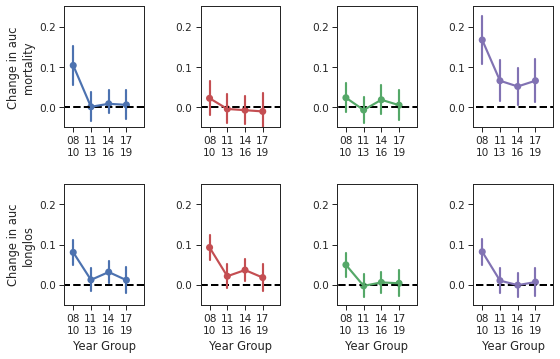

In [8]:
tasks = ['mortality','longlos']
imodels = ['lr','rf','xgb','nn']
fig, axes = plt.subplots(len(tasks),len(imodels),figsize=(8,6))
plt.tight_layout(w_pad=2,h_pad=3,rect=[0.05,0.15,1,0.95])
df_results = pd.DataFrame(columns=['task','model','group','CI_upper','CI_med','CI_lower'],dtype='float')
c=0
for i,task in enumerate(tasks):
    for j,model in enumerate(imodels):
        for group in groups:
            c+=1
            fpath = f"{results_fpath}/analysis_id={task}/{fi_fpath}"
            fname = f"{model}_2008 - 2010_{group}_perm_{analysis_tag}_inspect"
            df = pd.read_csv(f"{fpath}/{fname}.csv")
            df_random = df.query("metric=='auc' and features=='random'").groupby('perc_features').mean().reset_index()
            df_top = df.query("metric=='auc' and features=='top'")
            df_results.loc[c,:] = [
                task, model, group,
                np.mean(df_random.query("perc_features<1")['performance'].values - df_top.query("perc_features<1")['CI_lower'].values),
                np.mean(df_random.query("perc_features<1")['performance'].values - df_top.query("perc_features<1")['CI_med'].values),
                np.mean(df_random.query("perc_features<1")['performance'].values - df_top.query("perc_features<1")['CI_upper'].values)
            ]
        
        df_i = df_results.query("task==@task and model==@model")
        df_i = df_i.melt(id_vars=['task','model','group'],value_name='score')
        axes[i][j].plot(
            [-100,100],
            [0,0],
            color = 'black',
            linewidth = 2,
            linestyle ='--'
        )
        sns.pointplot(
            data = df_i,
            x = 'group',
            y = 'score',
            marker = 'o',
            ax = axes[i][j],
            color = model_colors[model]
        )
        
        axes[i][j].set_xticklabels(['08\n10','11\n13','14\n16','17\n19'])
        if i == len(tasks) -1:
            axes[i][j].set_xlabel('Year Group')
        else:
            axes[i][j].set_xlabel('')
        if j==0:
            axes[i][j].set_ylabel(f'Change in auc\n{task}')
        else:
            axes[i][j].set_ylabel('')
        axes[i][j].set_ylim([-0.05, 0.25])
        axes[i][j].set_xlim([-0.5,4])